In [14]:
import numpy as np
import corner
import normal_corner
import pickle

In [15]:

from itertools import combinations
from scipy.stats import multivariate_normal
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

def normal_corner(covm,mean,varlabels,fixedvarindex=None,fixedvarvalue=None,
           covm2=None,mean2=None,scale_factor=3,diagnostic=False,
                  color='red',color2='blue', fig=None, **fig_kw):
    '''Returns a corner plot, as a figure object, generated from
    covariance matrices and mean matrices, as numpy arrays.
    Also can plot a reducer order distribution on top.

    Main parameters:
    ----
    covm : numpy array [NxN]
        Covariance matrix for Normal distribution
    mean : numpy array [1xN]
        Array of mean values for Normal distribution
    varlabels : list of strings [1xN]
        list of labels for plotting, in LaTeX format, between $$

    (Some) additional parameters:
    ----
    fig : Matplotlib figure object
        Figure instance to plot to; can be the output of corner.corner
        to plot over MCMC corner plot
    **fig_kw : additional keyword are passed to figure()
    '''

    # Plotting 2D contour distributions
    N = len(mean)
    N_array = np.linspace(1,N,N,dtype=int)

    # Create figure and grid of axes if not provided
    axs=None
    init_axes=False
    if fig is None:
        fig, axx = plt.subplots(N, N, **fig_kw)
        init_axes=True

    if len(fig.axes) == N*N:
        axs=fig.axes
    else:
        axs=[plt.subplot(N, N, N*line+col+1) for line in range(N) for col in range(N)]
        init_axes=True

    if init_axes:
        for pair in combinations(N_array,2):
            # clear upper right triangle
            plot_idx = int(  N*(pair[0]-1)+(pair[1])  )
            ax=fig.axes[plot_idx-1]
            ax.set_visible(False)

    for pair in combinations(N_array,2):
        
        plot_idx = int(  N*(pair[1]-1)+(pair[0])  )
        
        pair2 = convert_pair(fixedvarindex,pair)
        
        lim = axis_limits(covm,mean,pair,covm2,mean2,pair2,scale_factor)

        ax=axs[plot_idx-1]
        
        ### Part that plots secondary corner plot ###
        if (not fixedvarindex==None) and (fixedvarindex+1 != pair[0]) and (fixedvarindex+1 != pair[1]):
            ax, cp2 = contour_plot_pair(ax,covm2,mean2,pair2,plot_idx,color2,lim,varlabels)
        
        ### Part that plots main corner plot ###
        ax, cp = contour_plot_pair(ax,covm,mean,pair,plot_idx,color,lim,varlabels)
        
        if diagnostic==True:
            print('ii',pair[0],'jj',pair[1])
            print('Plot idx:',plot_idx)
            print('-------------')
        
    # Plotting 1D histograms
    for pair in range(1,N+1):
        
        plot_idx = N*(pair-1)+pair
        
        pair2 = convert_pair(fixedvarindex,pair)
                    
        lim = axis_limits(covm,mean,pair,covm2,mean2,pair2,scale_factor)
     
        xvals = np.mgrid[lim['minvalx']:lim['maxvalx']:.01*(lim['maxvalx']-lim['minvalx'])]
        
        ax=axs[plot_idx-1]

        if (not fixedvarindex==None) and (fixedvarindex+1 != pair):
            ax.plot(xvals,norm.pdf(xvals, mean2[pair2[0]-1], covm2[pair2[0]-1][pair2[0]-1]**0.5),color=color2,linewidth=1)
        
        yvals=norm.pdf(xvals, mean[pair-1], covm[pair-1][pair-1]**0.5)
        ylim=ax.get_ylim()[1]*0.9
        yvals *= ylim/np.max(yvals)

        ax.plot(xvals,yvals,color=color,linewidth=1)
        ax = configure_axis(ax,N,plot_idx,varlabels)
        
        if diagnostic==True:
            print('ii, jj ',pair)
            print('Plot idx:',plot_idx)

    return fig

### Helper functions ###

def contour_plot_pair(ax,covm,mean,pair,plot_idx,color,lim,varlabels):
    
    twocov = covm[np.ix_([pair[0]-1,pair[1]-1],[pair[0]-1,pair[1]-1])]
    twomu = mean[np.ix_([pair[0]-1,pair[1]-1])]
    
    rv = multivariate_normal(twomu, twocov)
    
    rv_sigma=[]
    rv_sigma.append( rv.pdf( np.dstack((twomu[0], twomu[1]+3*twocov[1,1]**0.5)) ) )
    rv_sigma.append( rv.pdf( np.dstack((twomu[0], twomu[1]+2*twocov[1,1]**0.5)) ) )
    rv_sigma.append( rv.pdf( np.dstack((twomu[0], twomu[1]+1*twocov[1,1]**0.5)) ) )
    
    xvals, yvals = np.mgrid[lim['minvalx']:lim['maxvalx']:.01*(lim['maxvalx']-lim['minvalx']), lim['minvaly']:lim['maxvaly']:.01*(lim['maxvaly']-lim['minvaly'])]
    pos = np.dstack((xvals, yvals))
    
    cp = ax.contour(xvals, yvals, rv.pdf(pos), rv_sigma, colors=color, linestyles=['dotted','dashed','solid'],linewidths=1)
    ax = configure_axis(ax,len(mean),plot_idx,varlabels)
    
    return ax, cp

def axis_limits(covm,mean,pair,covm2,mean2,pair2,scale_factor):
    ''' Choose axis limits on the basis of two covariance matrices and a scale factor '''
    
    lim = dict()
    lim2 = dict()
    
    # Quick fix for 1D histogram with int pair
    if pair.__class__ == int:
        pair = [pair,pair]
        pair2 = [pair2[0],pair2[0]]
    
    lim['minvalx'] = mean[pair[0]-1]-scale_factor*covm[pair[0]-1][pair[0]-1]**0.5
    lim['maxvalx'] = mean[pair[0]-1]+scale_factor*covm[pair[0]-1][pair[0]-1]**0.5
    lim['minvaly'] = mean[pair[1]-1]-scale_factor*covm[pair[1]-1][pair[1]-1]**0.5
    lim['maxvaly'] = mean[pair[1]-1]+scale_factor*covm[pair[1]-1][pair[1]-1]**0.5
    
    if pair2[0] != None:
        
        lim2['minvalx'] = mean2[pair2[0]-1]-scale_factor*covm2[pair2[0]-1][pair2[0]-1]**0.5
        lim2['maxvalx'] = mean2[pair2[0]-1]+scale_factor*covm2[pair2[0]-1][pair2[0]-1]**0.5
        lim2['minvaly'] = mean2[pair2[1]-1]-scale_factor*covm2[pair2[1]-1][pair2[1]-1]**0.5
        lim2['maxvaly'] = mean2[pair2[1]-1]+scale_factor*covm2[pair2[1]-1][pair2[1]-1]**0.5
        
        lim['minvalx'] = min([lim['minvalx'],lim2['minvalx']])
        lim['maxvalx'] = max([lim['maxvalx'],lim2['maxvalx']])
        lim['minvaly'] = min([lim['minvaly'],lim2['minvaly']])
        lim['maxvaly'] = max([lim['maxvaly'],lim2['maxvaly']])
    
    return lim

def convert_pair(fixedvarindex,pair):
    ''' Convert pair variable to pair for a secondary covariance matrix '''
    
    # Quick fix for 1D histogram with int pair
    if pair.__class__ == int:
        pair = [pair]
        pair2 = [None]
    else:
        pair2 = [None, None]
    
    if fixedvarindex != None:
        for ii, pp in enumerate(pair):
            if pp>fixedvarindex+1:
                pair2[ii]=pp-1
            else:
                pair2[ii]=pp
    return pair2

def configure_axis(ax,N,plot_idx,varlabels):
    '''
    Remove axis for subplots that are not adjacent to bottom and left corner plot edges
    Set axis labels for remaining axis
    '''
    is_left, is_bottom = subplot_type(N,plot_idx)

    ax.tick_params(labelrotation=45)
    
    if not is_left or plot_idx==1:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel( subplot_label('y',N,plot_idx,varlabels) )

    if not is_bottom:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel( subplot_label('x',N,plot_idx,varlabels) )
        
    return ax
    
def subplot_type(N,plot_idx):
    '''
    Returns two bool values using number of rows/columns (N)
    and subplot's index (plot_idx):
     - First output for subplot being one of left side blocks
     - Second output for subplot being on of bottom blocks
    This function is used to deicide what subplots should have axis
    '''
    return (plot_idx+N-1)%N==0, plot_idx>N*(N-1)

def subplot_label(axis,N,plot_idx,varlabels):
    ''' Returns a label string for the selected axis '''
    label=''
    if axis=='x':
        label = varlabels[plot_idx%N-1]
    elif axis=='y':
        label = varlabels[(plot_idx-1)//N]
    return label

In [16]:
with open("./constrains_n_wst.res", "rb") as f:
    COV = pickle.load(f)

In [17]:
mean_vals = np.array((0.3175, 0.049, 0.6711, 0.9624, 0.834, 0, -1))

In [18]:
vars = ['$\\Omega_m$','$\\Omega_b$','$h$','$n_s$','$s_8$','$M_{\\nu}$','$w$']

ValueError: The input matrix must be symmetric positive semidefinite.

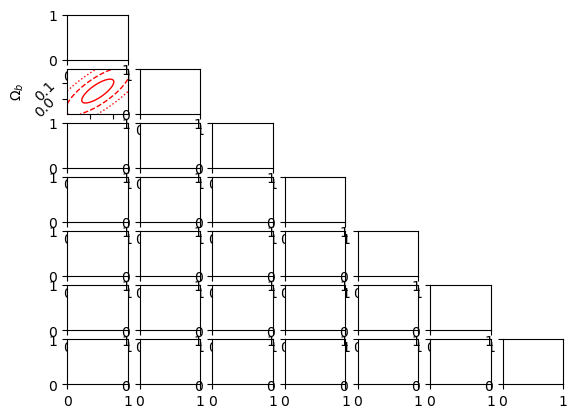

In [19]:
figure_1 = normal_corner(covm=COV, mean=mean_vals, varlabels=vars)

In [ ]:
normal_corner